## Mount Drive and Import Libraries


In [1]:
# system
import os
import sys
from tqdm.auto import tqdm

# mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_dir = "/content/drive/MyDrive/ThorMed/Kvasir-SEG"
sys.path.append(base_dir)
os.chdir(base_dir)

# data handling
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from train import train_model
from unet import UNet

# parameters
from config import *
from dataset import KvasirDataset
print("Modules imported.")

Mounted at /content/drive
Modules imported.


In [2]:
# data paths
dataset_dir = os.path.join(base_dir, 'Kvasir-SEG')
images_dir = os.path.join(dataset_dir, "images")
masks_dir = os.path.join(dataset_dir, "masks")
bbox_dir = os.path.join(dataset_dir, "bbox")
annotated_dir = os.path.join(dataset_dir, "annotated_images")

## Data Preprocessing

In [3]:
# get image ids
train_ids = pd.read_csv(os.path.join(base_dir, "train.txt"), header=None)[0].tolist()
val_ids = pd.read_csv(os.path.join(base_dir, "val.txt"), header=None)[0].tolist()
print(f"Number of training samples: {len(train_ids)} images")
print(f"Number of validation samples: {len(val_ids)} images")

all_ids = train_ids + val_ids
images = {}
masks = {}

for id in tqdm(all_ids):
    # get images
    img_path = os.path.join(images_dir, f"{id}.jpg")
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMG_SIZE)
    image = image / 255.0  # normalize to [0,1]

    # get masks
    mask_path = os.path.join(masks_dir, f"{id}.jpg")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMG_SIZE)
    mask = mask / 255.0  # normalize to [0,1]
    mask = (mask > 0.5).astype(np.float32)  # binarize mask

    # get PyTorch tensors
    image = torch.from_numpy(image).permute(2, 0, 1).float()  # convert to [256, 256, 3] -> [3, 256, 256]
    mask = torch.from_numpy(mask).float().unsqueeze(0)  # convert to [1, 256, 256]
    images[id] = image
    masks[id] = mask

print("\n Data loaded!")

Number of training samples: 880 images
Number of validation samples: 120 images


  0%|          | 0/1000 [00:00<?, ?it/s]


 Data loaded!


## Data Loading

In [5]:
train_dataset = KvasirDataset(train_ids, images, masks, augment=True)
val_dataset = KvasirDataset(val_ids, images, masks, augment=False)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

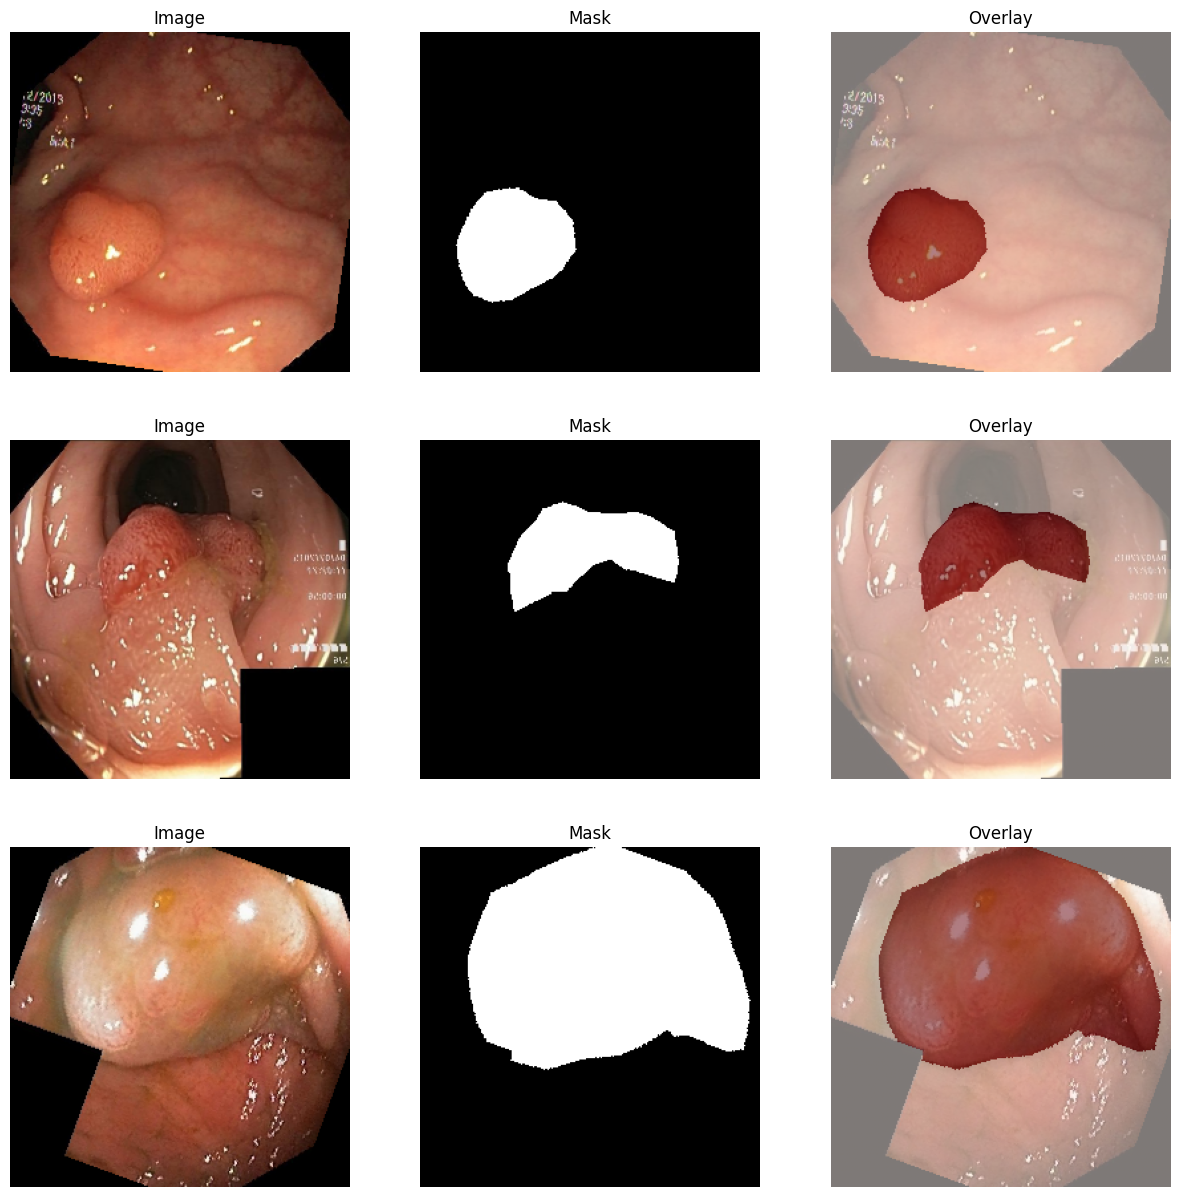

0


In [7]:
# display some training samples
num_samples = 3
plt.figure(figsize=(15, 5*num_samples))
data_iter = iter(train_loader)

for i in range(num_samples):
    # get batch and first image in batch
    images, masks = next(data_iter)
    image = images[0].permute(1, 2, 0).numpy()  # [C,H,W] -> [H,W,C] for matplotlib
    mask = masks[0].squeeze(0).numpy()  # remove channel dim

    # image
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # mask
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    # overlay
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5, cmap='Reds')
    plt.title('Overlay')
    plt.axis('off')

plt.show()

## Model Training


Model Architecture:
UNet(
  (encoder): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      

Training:   0%|          | 0/25 [00:00<?, ?epoch/s]

Epoch 1/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 1/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 1
Epoch [1/25], Train Loss: 0.531, Val Loss: 0.494


Epoch 2/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 2/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 2
Epoch [2/25], Train Loss: 0.425, Val Loss: 0.400


Epoch 3/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 3/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [3/25], Train Loss: 0.391, Val Loss: 0.415


Epoch 4/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 4/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 4
Epoch [4/25], Train Loss: 0.363, Val Loss: 0.360


Epoch 5/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 5/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [5/25], Train Loss: 0.344, Val Loss: 0.362


Epoch 6/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 6/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 6
Epoch [6/25], Train Loss: 0.331, Val Loss: 0.330


Epoch 7/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 7/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 7
Epoch [7/25], Train Loss: 0.318, Val Loss: 0.322


Epoch 8/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 8/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [8/25], Train Loss: 0.300, Val Loss: 0.368


Epoch 9/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 9/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 9
Epoch [9/25], Train Loss: 0.290, Val Loss: 0.302


Epoch 10/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 10/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [10/25], Train Loss: 0.279, Val Loss: 0.318


Epoch 11/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 11/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 11
Epoch [11/25], Train Loss: 0.273, Val Loss: 0.285


Epoch 12/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 12/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [12/25], Train Loss: 0.260, Val Loss: 0.292


Epoch 13/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 13/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 13
Epoch [13/25], Train Loss: 0.253, Val Loss: 0.284


Epoch 14/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 14/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [14/25], Train Loss: 0.243, Val Loss: 0.284


Epoch 15/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 15/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 15
Epoch [15/25], Train Loss: 0.241, Val Loss: 0.261


Epoch 16/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 16/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [16/25], Train Loss: 0.225, Val Loss: 0.266


Epoch 17/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 17/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 17
Epoch [17/25], Train Loss: 0.222, Val Loss: 0.257


Epoch 18/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 18/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [18/25], Train Loss: 0.216, Val Loss: 0.292


Epoch 19/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 19/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 19
Epoch [19/25], Train Loss: 0.206, Val Loss: 0.253


Epoch 20/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 20/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 20
Epoch [20/25], Train Loss: 0.201, Val Loss: 0.239


Epoch 21/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 21/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [21/25], Train Loss: 0.196, Val Loss: 0.250


Epoch 22/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 22/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch [22/25], Train Loss: 0.190, Val Loss: 0.241


Epoch 23/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 23/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 23
Epoch [23/25], Train Loss: 0.182, Val Loss: 0.231


Epoch 24/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 24/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 24
Epoch [24/25], Train Loss: 0.181, Val Loss: 0.218


Epoch 25/25 [Train]:   0%|          | 0/55 [00:00<?, ?batch/s]

Epoch 25/25 [Valid]:   0%|          | 0/8 [00:00<?, ?batch/s]

Model saved at epoch 25
Epoch [25/25], Train Loss: 0.176, Val Loss: 0.218


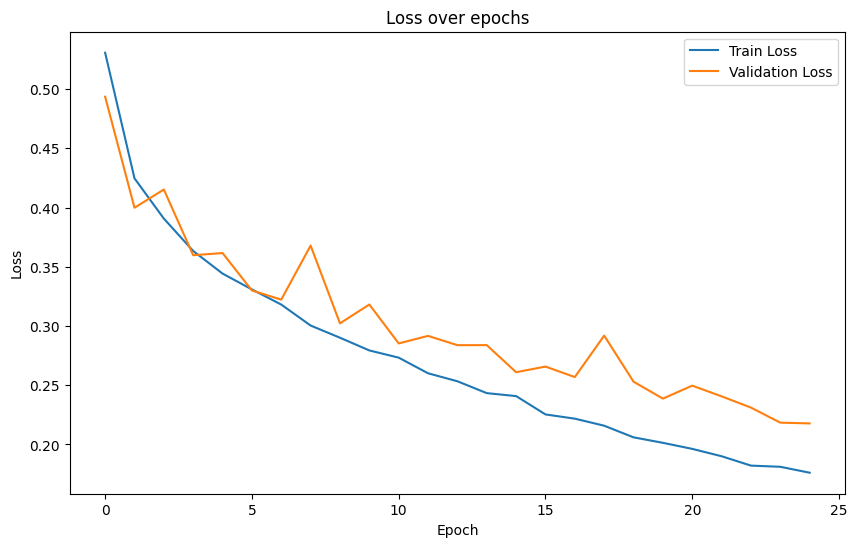

In [8]:
model = UNet().to(DEVICE)
output_dir = os.path.join(base_dir)
# model summary
print("\nModel Architecture:")
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# train model
print("\nStarting model training...")
model = train_model(model, train_loader, val_loader, DEVICE, base_dir, num_epochs=EPOCHS)

## Model Evaluation

In [8]:
# load best model and evaluate
print("\nLoading best model for evaluation...")
model.load_state_dict(torch.load(os.path.join(base_dir, 'best_model.pth')))
model.eval()
test_loss = 0.0
criterion = nn.BCELoss()

dice_scores = []
ious = []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, masks)

        test_loss += loss.item() * images.size(0)

        # calculate metrics
        pred_masks = (outputs > 0.5).float()

        # Dice
        intersection = torch.sum(pred_masks * masks, dim=[1, 2, 3])
        union = torch.sum(pred_masks, dim=[1, 2, 3]) + torch.sum(masks, dim=[1, 2, 3])
        dice = (2.0 * intersection) / (union + 1e-8)
        dice_scores.extend(dice.cpu().numpy())

        # IoU
        intersection = torch.sum(pred_masks * masks, dim=[1, 2, 3])
        union = torch.sum(pred_masks + masks > 0, dim=[1, 2, 3])
        iou = intersection / (union + 1e-8)
        ious.extend(iou.cpu().numpy())

test_loss = test_loss / len(val_loader.dataset)
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(ious)

print(f"Test Loss: {test_loss:.3f}")
print(f"Mean Dice Score: {mean_dice:.3f}")
print(f"Mean IoU: {mean_iou:.3f}")


Loading best model for evaluation...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Loss: 0.214
Mean Dice Score: 0.714
Mean IoU: 0.607


In [9]:
print("\nVisualizing some segmentation results...")

plt.figure(figsize=(15, 12))
model.eval()
images, masks = next(iter(val_loader))
outputs = model(images.to(DEVICE))
pred_masks = (outputs > 0.5).float()
num_samples_to_show = min(5, len(images))

for i in range(num_samples_to_show):
    # original image
    plt.subplot(3, num_samples_to_show, i + 1)
    img = images[i].permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # ground truth
    plt.subplot(3, num_samples_to_show, i + 1 + num_samples_to_show)
    gt_mask = masks[i].squeeze().cpu().numpy()
    plt.imshow(gt_mask, cmap='gray')
    plt.title(f"Ground Truth {i+1}")
    plt.axis('off')

    # prediction
    plt.subplot(3, num_samples_to_show, i + 1 + 2*num_samples_to_show)
    pred_mask = pred_masks[i].squeeze().cpu().detach().numpy()
    plt.imshow(pred_mask, cmap='gray')

    # metrics for this sample
    intersection = torch.sum(pred_masks[i] * masks[i].to(DEVICE)).item()
    union_dice = (torch.sum(pred_masks[i]) + torch.sum(masks[i].to(DEVICE))).item()
    union_iou = torch.sum((pred_masks[i] + masks[i].to(DEVICE)) > 0).item()

    dice = (2.0 * intersection) / (union_dice + 1e-8)
    iou = intersection / (union_iou + 1e-8)

    plt.title(f"Prediction {i+1}\nDice: {dice:.3f}, IoU: {iou:.3f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# overlay
plt.figure(figsize=(15, 10))
for i in range(num_samples_to_show):
    plt.subplot(2, num_samples_to_show, i + 1)
    img = images[i].permute(1, 2, 0).cpu().numpy()
    gt_mask = masks[i].squeeze().cpu().numpy()

    # green for ground truth
    # blue for prediction
    overlay = img.copy()
    overlay[gt_mask > 0.5] = [0, 1, 0]

    plt.imshow(overlay)
    plt.title(f"Ground Truth Overlay {i+1}")
    plt.axis('off')

    plt.subplot(2, num_samples_to_show, i + 1 + num_samples_to_show)
    img = images[i].permute(1, 2, 0).cpu().numpy()
    pred_mask = pred_masks[i].squeeze().cpu().detach().numpy()

    overlay = img.copy()
    overlay[pred_mask > 0.5] = [0, 0, 1]

    plt.imshow(overlay)
    plt.title(f"Prediction Overlay {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.